In [2]:
# POST COMPLEMENTAR PARA O VITALISET.GITHUB.IO: ESTRATÉGIAS DE FEATURE SELECTION DO SKLEARN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 8)

C:\Users\Carlo\anaconda3\envs\blog_datalab_boruta2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Boruta Feature Selection

Fazer uma seleção de variáveis adequada nos ajuda, principalmente, por que ter menos atributos nos retorna um modelo menos complexo e, consequentemente, com menos chance de se apegar em relações particulares da amostra utilizada para treino. Na prática, isso significa, menos chance de overfitting e, consequentemente, nos dá modelos mais estáveis e com melhor performance fora do laboratório. Por isso, na minha opinião, a seleção de variáveis é uma das mais poderosas ferramentas data-centric.

*$\oint$ Para ilustrar a afirmação anterior, temos, como exemplo, que a [dimensão-VC](https://youtu.be/Dc0sr0kdBVI) (medida de complexidade de uma família de hipóteses) de um perceptron (classificador linear) é $d+1$ em que $d$ é a número de variáveis utilizadas no modelo.* 

Entretanto, esse assunto não é visto com o cuidado devido na maioria dos cursos de Aprendizado de Máquina. São apresentados poucos métodos e de maneira superficial. Os poucos lugares que discutem o tema, no geral, focam ainda em técnicas que não são escaláveis com o aumento de variáveis e por isso são impraticáveis na maioria das aplicações do mercado (como as estratégias gulosas de [`sklearn.feature_selection.SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html)).

No DataLab, seleção de variáveis se torna extremamente relevante pela natureza dos problemas que trabalhamos. Na grande maioria dos casos temos algumas milhares de variáveis disponíveis no bureau de dados da Serasa e não é fácil identificar de antemão quais serão as features que nos darão mais ganhos. É necessário aplicar técnicas que são robustas à grandeza de variáveis que temos ao mesmo tempo que garantem uma seleção que faça sentido.

Neste post iremos motivar a construção do Boruta, uma das técnicas mais utilizadas pelos cientistas do DataLab na seleção de features, com algumas dicas de uso prático. Ilustraremos ainda o uso da função [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py), do ambiente [scikit-learn-contrib](https://github.com/scikit-learn-contrib/scikit-learn-contrib/blob/master/README.md) (ou seja, compátivel com bibliotecas que sigam o [padrão de código do scikit-learn](https://scikit-learn.org/stable/developers/develop.html).

___

Para ilustrar o problema de seleção de features, utilizaremos o [`sklearn.datasets.make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) para criar um problema genérico de classificação em que podemos definir, como um parâmetro da função, o número de variáveis úteis para o problema de previsão.

In [2]:
from sklearn.datasets import make_classification

N_FEATURES = 20

X, y = \
make_classification(n_samples=1000,
                    n_features=N_FEATURES,
                    n_informative=2,
                    n_redundant=2,
                    n_classes=2,
                    flip_y=0.1,
                    shuffle=False,
                    random_state=42)

X = pd.DataFrame(X, columns=[f'column_{i+1}' for i in range(N_FEATURES)])

X.head()

,column_1,column_2,column_3,column_4,...,column_17,column_18,column_19,column_20
0,-1.050478,-1.323568,0.912474,1.009796,...,1.800511,1.238946,0.209659,-0.491636
1,-1.580834,-2.747104,1.777419,1.850430,...,-0.524088,0.152355,-0.822420,1.121031
2,-0.885704,-0.614600,0.501004,0.631813,...,0.262561,0.193590,0.850898,-0.137372
3,-1.525438,-2.967793,1.884777,1.924410,...,-0.617652,-0.316073,0.615771,1.203884
4,-1.076826,-1.014619,0.752233,0.885267,...,0.326745,0.300474,0.622207,-1.138833


Como estamos escolhendo 2 features informativas e 2 features redundantes, temos que as 4 features mais importantes são as colunas: column_1, column_2, column_3 e column_4.

# Construção do Boruta

## Medindo a importância de uma variável

Uma das técnicas mais comuns para selecionar as variáveis é aproveitar-se de modelos que, de alguma forma, selecionam as variáveis no próprio processo de treinamento. Árvores e, consequentemente, cômites de árvores são talvez o melhor exemplo disso: pela [estratégia gulosa de fazer sempre a melhor quebra possível naquele instante](https://www.edureka.co/community/46109/what-is-greedy-approach-in-decision-tree-algorithm) (de acordo com algum critério de melhor, usualmente relacionada a pureza das folhas criadas, no caso de classificação), estamos sempre escolhendo a melhor quebra da melhor variável para ser feita naquela etapa. Variáveis pouco discriminativas são escolhidas muito menos que as variáveis que de fato ajudam a fazer a previsão.

Esse processo naturalmente deriva medidas de importâncias para as variáveis como: o número de vezes que ela é utilizada (esse é o modo default do atributo `.feature_importance_` dos ensembles do LGBM, como o [`lightgbm.LGBMClassifier`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)) ou uma ponderação do ganho de critério no processo de escolha das quebras das features (essa é a forma default dos ensembles de árvores do sklearn, como o [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), o [`sklearn.ensemble.ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), e o [`sklearn.ensemble.HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) e também vira o atributo do LGBM quando setamos o `importance_type='gain'`).

Vale comentar brevemente que no final, esses valores são normalizados de tal forma que `.feature_importances_.sum()` = 1.

Com alguma dessas medidas naturais de importância, é razoável ordenar nossas variáveis da mais importante para a menos importante.

In [11]:
rfc.feature_importances_.sum()==1

False

In [3]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42).fit(X, y)

df_imp = \
(pd.DataFrame(list(zip(X.columns, rfc.feature_importances_)),
              columns=['feature_name', 'feature_importance'])
 .sort_values(by='feature_importance', ascending=False)
 .reset_index(drop=True)
)

df_imp

,feature_name,feature_importance
0,column_2,0.278748
1,column_3,0.201150
2,column_4,0.092612
...,...,...
17,column_16,0.018641
18,column_18,0.017565
19,column_20,0.016912


*$\oint$ Existem algumas outras formas de metrificar a importância de uma variável, como por exemplo utilizando suas contribuições de [valores SHAP](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30). Como o [`shap.Explainer(model).shap_values(X)`](https://github.com/slundberg/shap) nos retorna uma medida de quanto aquela variável agregou na previsão, pegar a sua média entre todos os exemplos nos dá uma forma de ver o quão útil ela foi para discriminar os exemplos como um todo. Para os valores não se cancelarem (imagine uma variável que para determinados valores joga a previsão para cima e em outros valores joga a previsão para baixo), tomamos o módulo antes de fazer a média. Repare que a ordem das importâncias dada pelo SHAP pode ser diferente da ordem de importâncias dada pelo atributo de `.feature_importance_` usual do estimador, como é o caso do nosso exemplo.*

In [4]:
explainer = shap.TreeExplainer(rfc)
shap_vals = explainer.shap_values(X)

df_imp_shap = \
(pd.DataFrame(list(zip(X.columns, np.abs(shap_vals[0]).mean(axis=0))),
              columns=['feature_name', 'shap_importance'])
 .sort_values(by='shap_importance', ascending=False)
 .reset_index(drop=True)
)

df_imp_shap

,feature_name,shap_importance
0,column_2,0.197645
1,column_3,0.107211
2,column_4,0.043797
...,...,...
17,column_16,0.005268
18,column_5,0.005099
19,column_20,0.005019


*Ainda não falamos do Boruta, mas ele se utiliza dessa ordenação para fazer suas análises e é implementado, usualmente utilizando medida de importância do estimador (o atributo `.feature_importances_` ou `.coef_` para algoritmos lineares). Essa diferença motivou alguns contribuidores a implementar o [Boruta-Shap](https://github.com/Ekeany/Boruta-Shap). Infelizmente a biblioteca não é tão bem estruturada quanto a do Boruta. Minha sugestão é adaptar na mão o atributo `.feature_importance_` do seu classificador, fazendo algo como:*

```python
class SHAPImportanceRandomForestClassifier(RandomForestClassifier):
    def fit(self, X, y, sample_weight=None):
        self.X_ = X
        super().fit(X, y, sample_weight=sample_weight)
        return self
    @property
    def feature_importances_(self):
        check_is_fitted(self)
        explainer = shap.TreeExplainer(self)
        shap_vals = explainer.shap_values(self.X_)
        return np.abs(shap_vals[0]).mean(axis=0)
```

In [5]:
from shap_feature_importances_ import SHAPImportanceRandomForestClassifier

rfc_shap = SHAPImportanceRandomForestClassifier(random_state=42).fit(X, y)
rfc_shap.feature_importances_

array([0.04156985, 0.19764501, 0.10721142, 0.04379691, 0.00509938,
       0.00967927, 0.00900892, 0.00769202, 0.01053711, 0.00973848,
       0.00764462, 0.00725161, 0.00690175, 0.00718789, 0.00600269,
       0.00526766, 0.00659648, 0.00585107, 0.00726538, 0.00501896])

*Note que essa implementação utiliza o mesmo conjunto de treino para cálculo do SHAP. Existe algum debate aqui, mas tenha em mente que os valores de importância calculados com SHAP (média do valor absoluto) no teste podem ser diferentes dos valores de importância calculados com SHAP no treino. Se você quiser esse nível de preciosismo, pode estar interessado em reservar um pedaço do seu conjunto de dados para calcular os valores SHAP. Implemento essa ideia na classe `XSHAPImportanceRandomForestClassifier` do arquivo [`shap_feature_importances_.py`](link?) no [repositório desse post](link?). Para poder dormir tranquilo, tenha em mente que o `.feature_importances_` usual dos algoritmos baseados em árvore é calculado com o conjunto de treino, então calcular o SHAP no treino não é uma blasfêmia tão grande.*

## Selecionando as `K` melhores

Se queremos que nosso modelo tenha apenas as `K` features mais úteis, a maneira natural de escolher elas seria pegar as `K` variáveis com maiores valores de importância.

In [6]:
K = 4

(df_imp
 .head(K)
 .feature_name
 .to_list()
)

['column_2', 'column_3', 'column_4', 'column_1']

Essa é uma das estratégias mais comuns de se fazer seleção de features no mercado, mas levanta algumas questões. A primeira e mais imediata é: como escolher o número de variáveis `K` ideal. Nesse caso ilustrativo, sabemos que 4 variáveis é o número correto, mas na maioria dos casos de aplicação real é irrealista ter esse número de antemão.

*$\oint$ Uma estratégia muito utilizada, mas que não vamos focar muito, é aumentar a lista de features do modelo seguindo a ordenação dada pelo modelo treinado em todas as features. Encarando esse valor `K` como um hiper-parâmetro que estamos otimizando. No exemplo abaixo, fazemos isso de utilizando o [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ao construir uma classe `SelectKTop` utilizando o padrão necessário para os selecionadores de variáveis do scikit-learn, isto é, seguindo a forma que o [`sklearn.feature_selection.SelectorMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectorMixin.html) exige. Você pode ver a implementação dessa classe no arquivo [`selectktop_selector.py`](link?) no [repositório desse post](link?).*

In [7]:
from selectktop_selector import SelectKTop

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline

grid = \
(GridSearchCV(make_pipeline(SelectKTop(random_state=42), 
                            RandomForestClassifier(random_state=42)),
              param_grid={'selectktop__K': np.arange(1,N_FEATURES+1)},
              cv= RepeatedStratifiedKFold(n_splits=3, 
                                          n_repeats=1, 
                                          random_state=42),
              scoring='roc_auc',
#               verbose=3
             )
 .fit(X, y)
)

df_cv = \
(pd.DataFrame(grid.cv_results_)[['param_selectktop__K', 
                                 'mean_test_score', 
                                 'std_test_score']])

cv_best = \
(df_cv.
 sort_values(by='mean_test_score', ascending=False)
 .reset_index(drop=True)
 .loc[0]
)

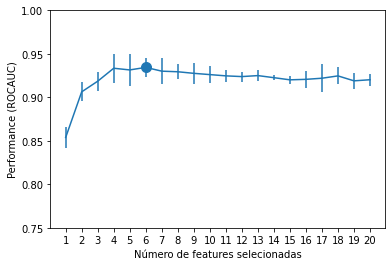

In [8]:
plt.errorbar(df_cv.param_selectktop__K, df_cv.mean_test_score, 1.96*df_cv.std_test_score)
plt.scatter(cv_best.param_selectktop__K, cv_best.mean_test_score, s=100)
plt.ylim(0.75, 1)
plt.xlabel('Número de features selecionadas')
plt.xticks(df_cv.param_selectktop__K.astype(int))
plt.ylabel('Performance (ROCAUC)')
plt.show()

*No nosso experimento controlado, encontramos algumas poucas variáveis a mais do que o correto.*

In [9]:
grid.best_estimator_.steps[0][1].get_feature_names_out()

array(['column_1', 'column_2', 'column_3', 'column_4', 'column_6',
       'column_10'], dtype=object)

*Vale citar que esse método pode ser deixado mais robusto variando o `random_seed` do `base_estimator` e tendo uma distribuição de importâncias para cada variável ao invés de apenas um valor único (que naturalmente é mais ruídoso). Utilizar essa técnica, mas com o SHAP para medir a importância (passando por exemplo o `SHAPImportanceRandomForestClassifier` como `base_estimator` do `SelectKTop`) é uma técnica muito utilizada por alguns cientistas do DataLab como alternativa ao Boruta, que costuma ser mais demorado.*

## Selecionando as `K` melhores incluindo uma variável aleatória

Criar uma variável de ruído, ou seja, que sabidamente não é útil para a previsão, nos auxiliar a ter um ponto de corte para filtro das variáveis que demonstram ajudar na previsão. A ideia dessa abordagem é medir a importância da variável aleatória e ficar apenas com variáveis que se demonstraram mais importantes.

Adicionando a nova coluna, por exemplo, amostrada de uma variável aleatória $\mathcal{N}(0,1)$ de forma independente, temos uma nova lista de importância das variáveis.

In [28]:
noised_X = (X.assign(noise_column = np.random.RandomState(42).normal(size=X.shape[0])))
noised_X[noised_X.columns[::-1]].head()

,noise_column,column_20,column_19,column_18,...,column_4,column_3,column_2,column_1
0,0.496714,-0.491636,0.209659,1.238946,...,1.009796,0.912474,-1.323568,-1.050478
1,-0.138264,1.121031,-0.822420,0.152355,...,1.850430,1.777419,-2.747104,-1.580834
2,0.647689,-0.137372,0.850898,0.193590,...,0.631813,0.501004,-0.614600,-0.885704
3,1.523030,1.203884,0.615771,-0.316073,...,1.924410,1.884777,-2.967793,-1.525438
4,-0.234153,-1.138833,0.622207,0.300474,...,0.885267,0.752233,-1.014619,-1.076826


In [29]:
noised_rfc = RandomForestClassifier(random_state=42).fit(noised_X, y)

df_imp_normal_noise = \
(pd.DataFrame(list(zip(noised_X.columns, noised_rfc.feature_importances_)),
              columns=['feature_name', 'feature_importance'])
 .sort_values(by='feature_importance', ascending=False)
)

df_imp_normal_noise

,feature_name,feature_importance
1,column_2,0.266446
2,column_3,0.205667
3,column_4,0.087548
...,...,...
4,column_5,0.018706
18,column_19,0.018264
19,column_20,0.017692


Como a última variável é a nossa coluna sabidamente ruídosa, a ideia dessa técnica é selecionar apenas as variáveis que tem importância maior do que o limiar settado pela importância da variável não relacionada.

In [38]:
np.array(
 df_imp_normal_noise
 .query(f"feature_importance > {noised_rfc.feature_importances_[-1]}")
 .feature_name
)

array(['column_2', 'column_3', 'column_4', 'column_1', 'column_6',
       'column_10', 'column_14'], dtype=object)

Vale observar que a escolha da variável ruídosa como $\mathcal{N}(0,1)$ foi totalmente arbitrária. Entretanto isso faz diferença e pode fazer a seleção de variáveis ser diferente. No nosso exemplo controlado, mudar o ruído para $\textrm{Exp}(1)$ nos faria selecionar variáveis finais diferentes, totalmente, por sorte.

In [39]:
noised2_X = (X.assign(noise_column = np.random.RandomState(42).exponential(size=X.shape[0])))
noised2_rfc = RandomForestClassifier(random_state=0).fit(noised2_X, y)

np.array(
 pd.DataFrame(list(zip(noised2_X.columns, noised2_rfc.feature_importances_)),
              columns=['feature_name', 'feature_importance'])
 .sort_values(by='feature_importance', ascending=False)
 .query(f"feature_importance > {noised_rfc.feature_importances_[-1]}")
 .feature_name
)

array(['column_2', 'column_3', 'column_4', 'column_1', 'column_14',
       'column_6', 'column_10', 'column_9'], dtype=object)

Isso nos demonstra um problema desse método. Apesar de poderoso, por nos dar um jeito interessante de selecionar as variáveis sem escolher `K` de forma arbitrária, a escolha da distribuição da variável ruídosa é uma fonte de variação relevante.

Em muitos casos, ter variáveis discretas *versus* contínuas pode influenciar na medida de importância (como é o caso de árvores que, por ter mais quebras disponíveis, terão mais chance de escolher uma variável ruídosa contínua) ou a própria escala da feature adicionada pode atrapalhar nessa mensuração (por exemplo, por estarmos usando os coefiencientes angulares de um [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)).

Toda essa variabilidade pode fazer uma *feature* ruim ser selecionada as vezes e em outras vezes uma variável boa ser discartada simplemente por azar.

O Boruta vem para tentar lidar com essas duas questões ao mesmo tempo: tentar manter a distribuição marginal das features ruídosas iguais às distribuições marginais das features originais, enquanto tenta ser robusto à variabilidade, repetindo o experimento algumas vezes.

## Ideias gerais do Boruta

Já existem muitos textos úteis que explicam o Boruta de forma didática e com exemplos. Como a ideia desse post não é ser redundante com a literatura e sim compilar ideias centrais de uso prático, vamos apenas citar os principais aspectos e deixar o convite para uma leitura detalhada de outras referências do tema como o post [Boruta Explained Exactly How You Wished Someone Explained to You](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a). A construção que fizemos anteriormente vão deixar as ideias do Boruta ainda mais claras, justificando o modo de serem.

Em resumo, o Boruta:
- Cria variáveis não correlacionadas com a target ao embaralhar, entre as linhas, variáveis já presentes no dataset. Essas são as variáveis que chamamos de *shadow*.
- Lida com a variabilidade repetindo o processo várias vezes e marcando quantas vezes a nossa variável de interesse ficou atrás do percentil `perc` dos `.feature_importances` das *shadow features* (por default, `perc=100`, e portanto comparamos com o máximo dos `.feature_importances` das *shadow features*, isto é, se alguma *shadow* for melhor, já descartamos aquela variável de interesse naquela rodada).
- Por fim, um teste de hipótese é feito para avaliar se podemos afirmar com alguma significância estatítica `alpha` que a feature de interesse é melhor que o percentil `perc` da importância das *shadow features*.
- Do teste de hipótese ele divide o conjunto de features em três categorias:
    - Aquelas que "com certeza" são melhores que os ruídos introduzidos pelas *shadow features* (`.support_`);
    - Aquelas que "com certeza" não são melhores que com certeza são equivalentes às variáveis *shadow*;
    - Aquelas que não é possível afirmar com significância estatística (`.weak_support_`).
- Na prática, a partir do momento que ele tem confiança que uma determinada variável não é importante, ele já exclui ela das próximas iterações.

## Uso do Boruta

Primeiro, precisamos instanciar um `base_estimator` que será utilizado dentro do Boruta para calcular a importância das variáveis (através do `.feature_importances_` ou do `.coef_`). É importante ressaltar que podemos adicionar hiper-parâmetros que acharmos relevantes para o problema, com o `class_weight` para o problema desbalanceado.

Quando usamos cômites de árvores (sejamos honestos, sempre), é importante ter em mente que árvores profundas vão mudar o `.feature_importances_`, mas vão demorar mais para treinar. É razoável utilizar árvores mais rasas, uma vez que os ganhos mais expressivos são feitos nas primeiras quebras usualmente. Como rodaremos o algoritmo mais rápido, podemos aumentar o número de rodadas que o Boruta vai rodar por isso.

In [14]:
from boruta import BorutaPy

boruta_forest = RandomForestClassifier(max_depth=10, random_state=42)

Um ponto de atenção importante que não é necessariamente claro na documentação, é que o parâmetro `n_estimators` do Boruta sobrescreve o `n_estimators` do estimador como podemos ver no [código fonte do BorutaPy](https://github.com/scikit-learn-contrib/boruta_py/blob/0.3/boruta/boruta_py.py#L268):
```python
# set n_estimators
if self.n_estimators != 'auto':
    self.estimator.set_params(n_estimators=self.n_estimators)
```
Por default, `n_estimators=1000`. Se `n_estimators='auto'`, então [uma regra baseada no número de features que estamos avaliando é feita para escolher o número de árvores do cômite](https://github.com/scikit-learn-contrib/boruta_py/blob/0.3/boruta/boruta_py.py#L371).

Por fim, `alpha` e `perc` são os outros parâmetros importantes do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) que você deveria ficar atento:
- O `perc` (percentil do `.feature_importances_` das *shadow features* utilizado para decidir se as variáveis foram boas ou não naquela determinada rodada) é um `int` que vai de 0 a 100. Quanto mais próximo de 100, mais rigoroso estamos sendo na hora de avaliar nossas features. Por sorte, alguns `.feature_importances_` de *shadow features* podem ser grandes e ser muito rigoroso com o critério de corte pode ser ruim porque estaremos excluindo variáveis marginais que são relevantes, mas não tem uma importância tão expressiva. O default desse parâmetro é 100.
- O `alpha` é um float que vai de 0 até 1 e será importante para delimitar a partição que fazemos do conjunto de variáveis (`.support_weak_`, `.support` e excluídas) uma vez que determinará o rigor de certeza que queremos ter para afirmar que uma determinada feature é relevante ou não para o problema de classificação (ou regressão). O default desse parâmetro é 0.05.

In [15]:
%%time

boruta = BorutaPy(
   estimator = boruta_forest,
   max_iter = 100, # number of trials to perform
   random_state = 42
)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))

BorutaPy(estimator=RandomForestClassifier(max_depth=10, n_estimators=1000,
                                          random_state=RandomState(MT19937) at 0x23BF0CEFE40),
         random_state=RandomState(MT19937) at 0x23BF0CEFE40)

Por fim, é fácil resgatar as features com os atributos `.support_` e `.support_weak_`, como já foi comentado.

In [20]:
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()

green_area, blue_area

(['column_1', 'column_2', 'column_3', 'column_4', 'column_6', 'column_10'],
 ['column_9', 'column_14'])

In [30]:
boruta.support_

array([ True,  True,  True,  True, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False])

## Tunnando o `perc`

Os parâmetros usuais do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) costumam funcionar muito bem quando temos um número de variáveis baixo. Entretanto, quando temos muitas *features*, criaremos muitas *shadow features* e portanto a restrição de `perc=100` pode ser forte demais.

Faremos um pequeno experimento em que variaremos número de feature do nosso dataset e veremos quantas features relevantes estamos pegando, fixado um valor de `perc`.

In [29]:
from tqdm import tqdm

In [39]:
# colocar isso daqui tudo dentro de um .py \/

In [36]:
val=[]

for N_FEATURES_exp in tqdm(np.linspace(100, 500, 9).astype(int)):
    X_exp, y_exp = \
    make_classification(n_samples=10000,
                        n_features=N_FEATURES_exp,
                        n_informative=int(0.2*N_FEATURES_exp),
                        n_redundant=0,
                        n_classes=2,
                        flip_y=0.1,
                        shuffle=False,
                        random_state=42)
    
    X_exp = pd.DataFrame(X_exp, columns=[f'column_{i+1}' for i in range(N_FEATURES_exp)])
    
    boruta_exp = BorutaPy(
        estimator = RandomForestClassifier(max_depth=7, random_state=42),
        n_estimators=100,
        max_iter = 100,
        random_state = 42
    )

    boruta_exp.fit(np.array(X_exp), np.array(y_exp))
    
    green_area_exp = X_exp.columns[boruta_exp.support_].to_list()
    blue_area_exp = X_exp.columns[boruta_exp.support_weak_].to_list()
    
    # mexer nisso
    val.append(len(set(green_area_exp+blue_area_exp)
                   .intersection(set([f'column_{i+1}' for i in range(int(0.2*N_FEATURES_exp))]))))

100%|██████████| 9/9 [31:49<00:00, 212.18s/it]


In [37]:
# plotar isso pra perc= 100, 90, 80, 70, 60

Como podemos ver, o Boruta demora razoavelmente bastante. Uma coisa que pode ajudar é fazer um undersample da base de desenvolvimento e filtrar as variáveis a partir apenas dessa amostra. Vamos fazer um último experimento em que, com os parametros do [`boruta.BorutaPy`](https://github.com/scikit-learn-contrib/boruta_py) estão fixados, mas mexemos no `frac` do `X.sample` e veremos se perdemos muito ao filtrar nosso conjunto de dados para ganhar tempo.

In [38]:
# TO DO ^^^^ 

# MEDIR TEMPO

# Conclusões

TODO

___

___

**IGNORAR DAQUI PRA BAIXO**

## Sequential Selector

O primeiro algoritmo que iremos discutir é a técnica de seleção sequencial. A ideia aqui é utilizar uma estratégia gulosa para explorar o número de combinações possíveis de variáveis que temos disponível. A príncipio, temos `2**N_FEATURES` formas diferentes de escolher as `N_FEATURES` disponíveis. Construir todos esses `2**N_FEATURES` modelos é impraticavel. No nosso simples exemplo, com apenas 20 features, teríamos `1048576` combinações diferentes. Se cada modelo demorasse 1 segundo para ser treinado e avaliado, esperaríamos 12 dias até termos todos esses resultados. Com 5 features a mais, teríamos que esperar mais de 1 ano.

A ideia da busca gulosa é escolher uma feature de cada vez para ser adicionada (ou removida) da lista de features selecionadas e observar a mudança na performance do modelo.

Por exemplo, na direção "para frente", podemos comparar o modelo sem nenhuma variável (por exemplo um modelo que retorna alguma estatística dos `y_train`, como a moda, no caso de claissificação, ou uma média/mediana no caso de uma regressão) como todos os `N_FEATURES` modelos possíveis com 1 variável. A variável do modelo que tiver a melhor performance entre os `N_FEATURES` modelos de 1 variável é escolhida para ser a primeira variável selecionada. Para escolher a possível segunda variável, fazemos a mesma coisa comparando 


```python
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(estimator, direction = "forward", n_features_to_select=3)
# other optionfor direction: "backward"
sfs.fit(X, y)
feature_mask = sfs.get_support()
X_selected_features = sfs.transform(X)
```

This Sequential Feature Selector adds (forward selection) or removes (backward selection) features to form a feature subset in a greedy fashion (one feature at a time).

Cons: Even with the greedy approach, it's expensive.

## Variance Selector

```python
from sklearn.feature_selection import VarianceThresholdn

selector = VarianceThreshold()
selector.fit(X)
X_selected_features = selector.transform(X)
```

Feature selector that removes all low-variance features.

Cons: which threshold to pick?

## K-Best Selector

SelectKBest is probably the most common technique. We simply select features according to the k highest scores (some measure of feature importances).

For instance, you can take the most "correlated" features to the target:
```python
from sklearn.feature_selection import SelectKBest, mutual_info_regression

X_selected_features = SelectKBest(mutual_info_regression, k=20).fit_transform(X, y)

```

In practice, we normaly use it with some model measure of feature importances.

### SelectorMixin pro variável ruído:

In [40]:
from scipy.stats import norm

In [54]:
# norm(loc=10, scale=3).rvs(size=1000, random_state=42)

array([11.49014246,  9.5852071 , 11.94306561, 14.56908957,  9.29753988,
        9.29758913, 14.73763845, 12.30230419,  8.59157684, 11.62768013,
        8.60974692,  8.60281074, 10.72588681,  4.26015927,  4.8252465 ,
        8.31313741,  6.96150664, 10.942742  ,  7.27592777,  5.7630889 ,
       14.39694631,  9.3226711 , 10.20258461,  5.72575544,  8.36685183,
       10.33276777,  6.54701927, 11.12709406,  8.19808393,  9.12491875,
        8.19488016, 15.55683455,  9.95950833,  6.82686721, 12.46763474,
        6.33746905, 10.62659079,  4.12098963,  6.01544185, 10.59058371,
       12.21539974, 10.51410484,  9.65305515,  9.09668891,  5.56443403,
        7.84046737,  8.61808369, 13.17136668, 11.03085487,  4.71087953,
       10.97225191,  8.84475316,  7.969234  , 11.83502887, 13.09299857,
       12.79384036,  7.48234743,  9.07236287, 10.99379029, 12.92663538,
        8.56247729,  9.44302307,  6.68099508,  6.41138013, 12.43757747,
       14.06872009,  9.78396964, 13.01059869, 11.08490808,  8.06

In [58]:
from typing import Type
from scipy.stats._distn_infrastructure import rv_continuous
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectorMixin
from sklearn.utils.validation import check_is_fitted

class SelectAboveNoise(SelectorMixin, BaseEstimator):
    """
    ...

    """

    # não é sklearn API friendly, mas acho útil aqui
    def __init__(self, sampler:Type[rv_continuous], base_estimator=None, random_state=None):
        self.sampler = sampler
        self.base_estimator = base_estimator
        self.random_state = random_state

    def _validate_estimator(self, default):
        if self.base_estimator is not None:
            self.base_estimator_ = self.base_estimator
        else:
            self.base_estimator_ = default
    
    def fit(self, X, y):
        
        X = self._validate_data(
            X,
            dtype=np.float64,
        )
        
        self._validate_estimator(RandomForestClassifier(random_state=self.random_state))
        
        self.base_estimator_.fit(X, y)
        
        self._selected_index_list_ = \
        (pd.DataFrame(list(zip(range(self.n_features_in_), self.base_estimator_.feature_importances_)),
                      columns=['feature_name', 'feature_importance'])
         .sort_values(by='feature_importance', ascending=False)
         .head(self.K)
         .index
         .to_list()
        )
        
        return self
    
    def _get_support_mask(self):
        check_is_fitted(self)
        return np.array([feat in self._selected_index_list_ for feat in range(self.n_features_in_)])
